# import library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# 시계열 데이터 준비

In [7]:
# 데이터 분리
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

# 각종 전처리 수행

In [9]:
# 결측치 확인
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

In [10]:
# 결측치 처리
# ts=ts.interpolate(method='time')

# 시계열 안정성 분석

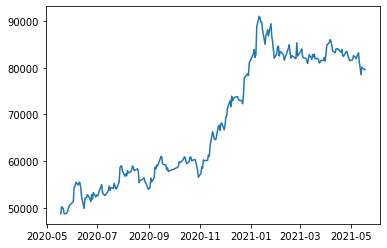

In [12]:
# 안정성 확인
plt.plot(ts)

In [7]:
# 구간 평균 / 표준편차 시각화 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

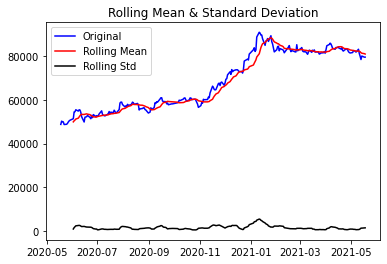

In [15]:
plot_rolling_statistics(ts, window=12)

In [9]:
# timeseries에 대한 Augmented Dickey-Fuller Test 수행 함수
def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')  
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [18]:
# timeseries에 대한 Augmented Dickey-Fuller Test
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


### p-value가 0에 가깝지 않기 때문에 주어진 시계열 데이터가 안정적이지 않다라는 귀무가설이 옳다고 하기 어렵다.

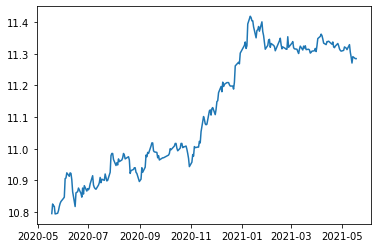

In [19]:
# 로그 변환 시도 
ts_log = np.log(ts)
plt.plot(ts_log)

In [20]:
# 로그 변환된 timeseries에 대한 Augmented Dickey-Fuller Test 수행 함수
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


### p-value가 줄어들긴 했지만 아직 부족하다

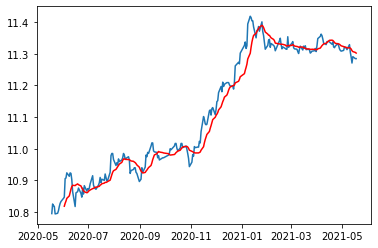

In [21]:
# trend 상쇄를 위해 moving average 구하기 
moving_avg = ts_log.rolling(window=12).mean()  
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [22]:
# timeseries에서 변화량 제거
ts_log_moving_avg = ts_log - moving_avg 
ts_log_moving_avg.head(15)

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22         NaN
2020-05-25         NaN
2020-05-26         NaN
2020-05-27         NaN
2020-05-28         NaN
2020-05-29         NaN
2020-06-01         NaN
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
Name: Close, dtype: float64

In [23]:
# window 크기 때문에 발생하는 NaN 값제거 (앞의 11개의 데이터)
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
2020-06-09    0.061925
2020-06-10    0.049636
2020-06-11    0.021446
2020-06-12   -0.019996
2020-06-15   -0.066141
2020-06-16   -0.025267
2020-06-17   -0.024961
2020-06-18   -0.024494
2020-06-19   -0.010603
2020-06-22   -0.023697
Name: Close, dtype: float64

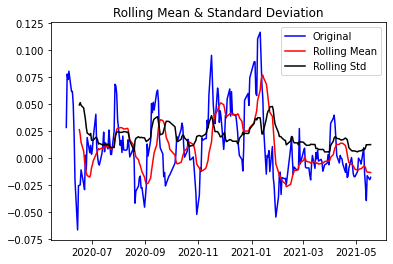

In [24]:
# 정성, 정량적 분석
plot_rolling_statistics(ts_log_moving_avg)

In [25]:
# timeseries에 대한 Augmented Dickey-Fuller Test 수행 함수
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                  -4.163469
p-value                          0.000759
#Lags Used                       0.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


### p-value가 0에 가까워졌기 때문에 이 time series는 stationary하다고 할 수 있다

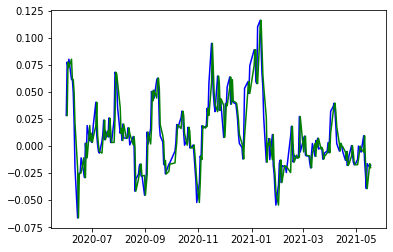

In [26]:
# 한 스텝 앞으로 시프트한 시계열과 원본 시계열
ts_log_moving_avg_shift = ts_log_moving_avg.shift()
plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

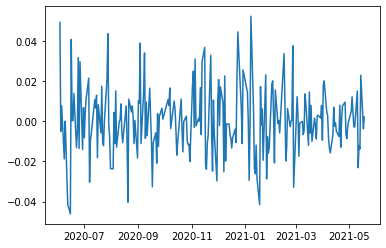

In [27]:
# 각 스텝에서 발생한 변화량 (차분(Differencing))
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

In [28]:
# 안정성(stationary) 여부 파악
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.546028e+01
p-value                        2.711476e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


### 로그 변환 이후로 지금까지의 변환을 한번에 해주는 함수가 있기 때문에 그것을 이용하기로 함

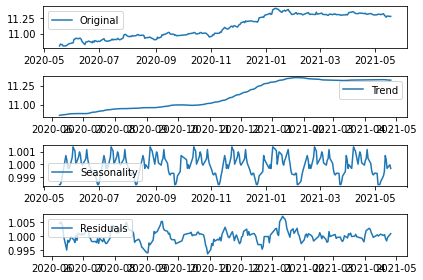

In [30]:
# 시계열 안에 존재하는 trend, seasonality를 직접 분리
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

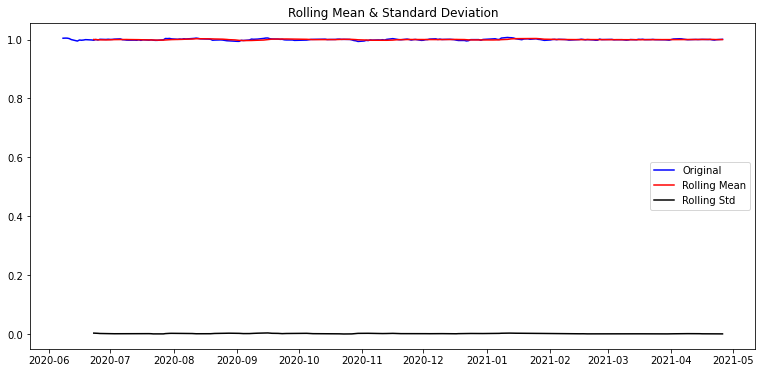

In [31]:
# residual 정성, 정량적 분석
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [32]:
# Residual에 대한 안정성 여부 판단
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


# 적정 ARIMA 모수 찾기

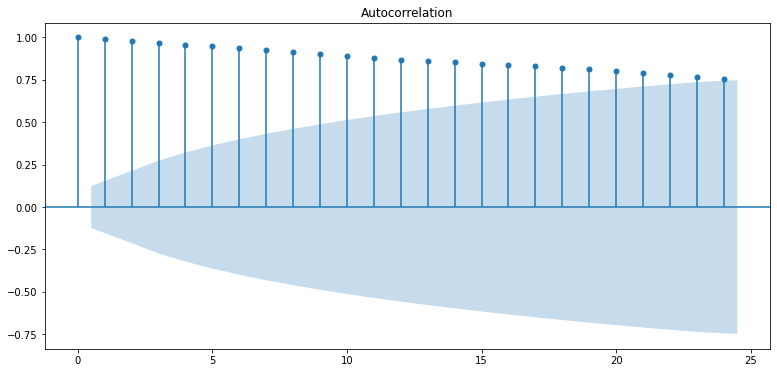

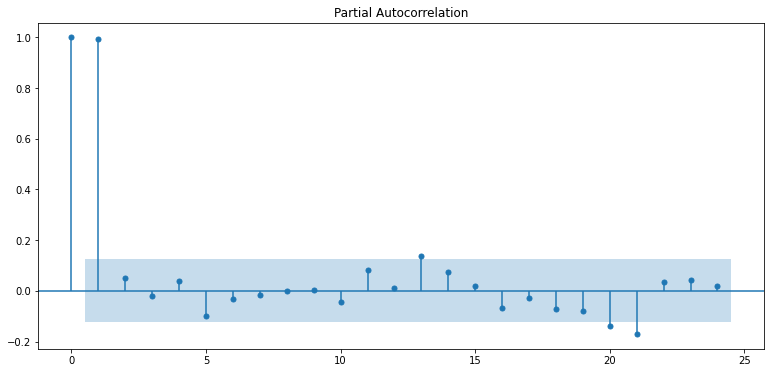

In [34]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### PACF 그래프에서 p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문에 p=1이 매우 적합한 것으로 판단

### ACF는 점차적으로 감소하면서 AR(1) 모델에 유사한 형태를 보이고 있기 때문에 q에 대해서는 적합한 값이 없어 보임 (q=0에서 q를 바꿔 가면서 확인 예정)

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


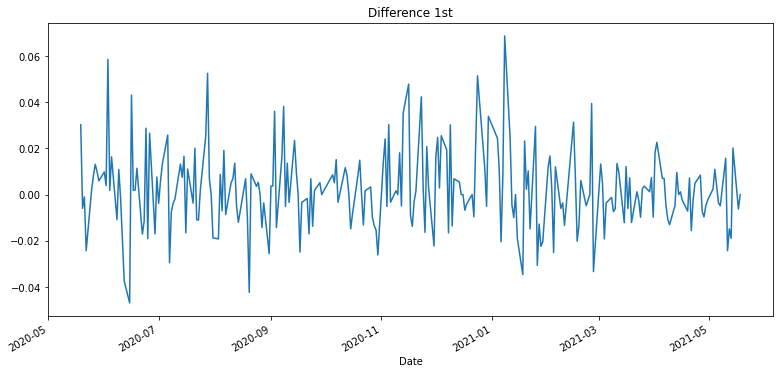

In [37]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


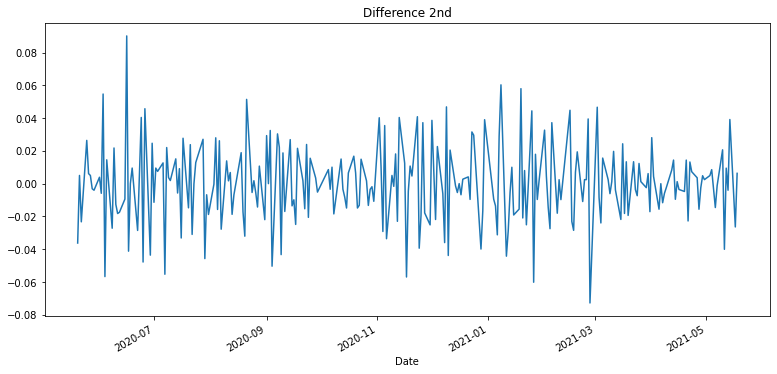

In [38]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### d=1에서 부터 d 값을 바꿔 가면서 최적의 값 탐색 예정

# 학습, 테스트 데이터셋 생성

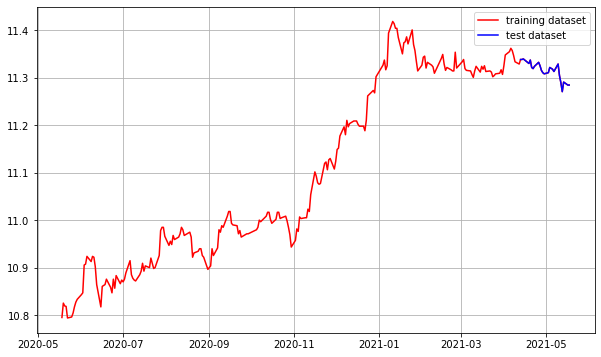

In [33]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [39]:
# 데이터 셋 형태 확인
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2020-05-18    10.795486
2020-05-19    10.825760
Name: Close, dtype: float64
(225,)
(25,)


#  ARIMA 모델 훈련과 테스트

In [41]:
# 모델 정의
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  224
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 585.396
Method:                       css-mle   S.D. of innovations              0.018
Date:                Sat, 04 Sep 2021   AIC                          -1164.792
Time:                        13:45:36   BIC                          -1154.557
Sample:                             1   HQIC                         -1160.661
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      1.978      0.048    2.17e-05       0.005
ar.L1.D.Close     0.0168      0.067      0.250      0.803      -0.115       0.148
                                    Root

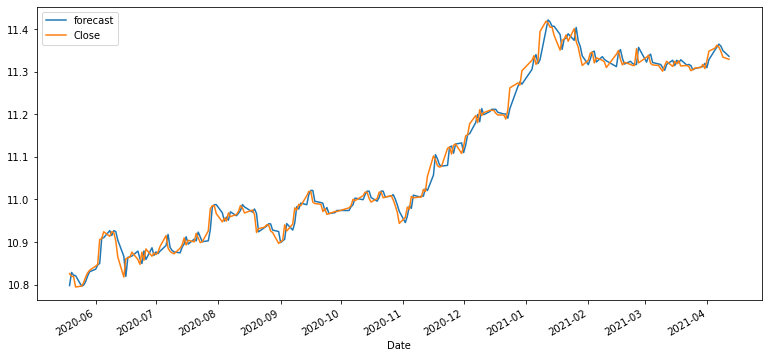

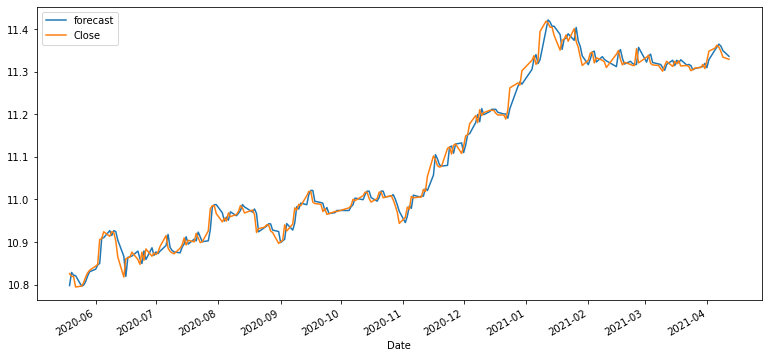

In [42]:
# 훈련 결과
fitted_m.plot_predict()

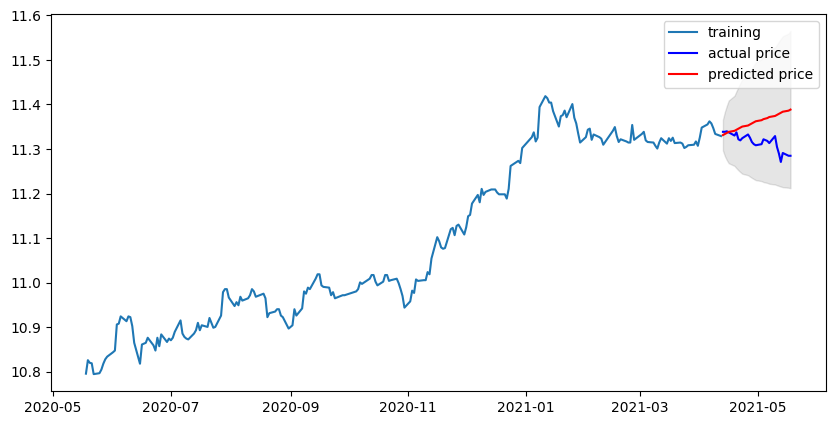

In [43]:
# 테스트 데이터 구간 예측

# Forecast : 결과가 fc에 저장 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# series로 만듦
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [45]:
# 오차계산

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22087366.126154922
MAE:  3791.3511527213127
RMSE:  4699.719792301976
MAPE: 4.68%


# 다른 주식 종목 예측해 보기

## Tesla

In [4]:
# 데이터 분리
dataset_filepath2 = os.getenv('HOME') + '/aiffel/stock_prediction/TSLA.csv'
df2 = pd.read_csv(dataset_filepath2, index_col='Date', parse_dates=True)
ts2 = df2['Close']

ts2.head()

Date
2020-09-04    418.320007
2020-09-08    330.209991
2020-09-09    366.279999
2020-09-10    371.339996
2020-09-11    372.720001
Name: Close, dtype: float64

In [6]:
# 결측치 확인
ts2[ts2.isna()]

Series([], Name: Close, dtype: float64)

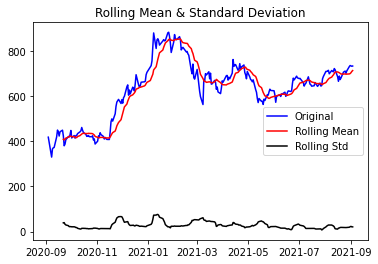

In [8]:
plot_rolling_statistics(ts2, window=12)

In [10]:
# timeseries에 대한 Augmented Dickey-Fuller Test
augmented_dickey_fuller_test(ts2)

Results of Dickey-Fuller Test:
Test Statistic                  -1.771682
p-value                          0.394609
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


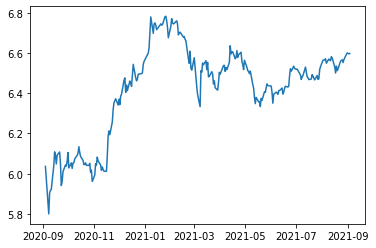

In [11]:
# 로그 변환 시도 
ts_log2 = np.log(ts2)
plt.plot(ts_log2)

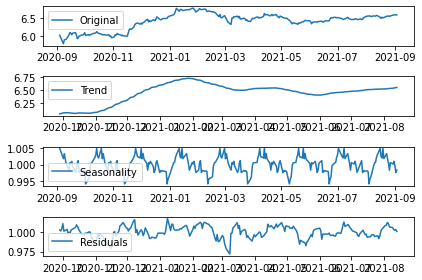

In [12]:
# 시계열 안에 존재하는 trend, seasonality를 직접 분리
decomposition2 = seasonal_decompose(ts_log2, model='multiplicative', period = 30) 

trend2 = decomposition2.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal2 = decomposition2.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual2 = decomposition2.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log2, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend2, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal2,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual2, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [13]:
# Residual에 대한 안정성 여부 판단
residual2.dropna(inplace=True)
augmented_dickey_fuller_test(residual2)

Results of Dickey-Fuller Test:
Test Statistic                  -5.122206
p-value                          0.000013
#Lags Used                       0.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64


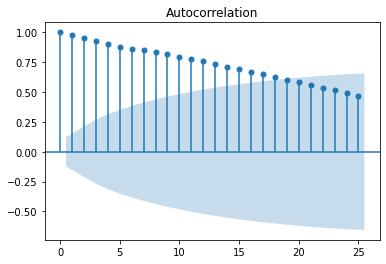

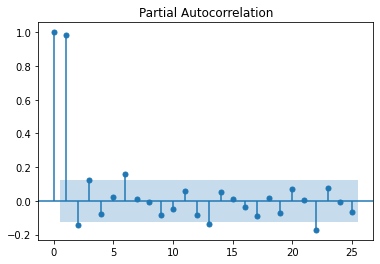

In [14]:
plot_acf(ts_log2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### PACF 그래프에서 p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문에 p=1이 매우 적합한 것으로 판단
### ACF는 점차적으로 감소하면서 AR(1) 모델에 유사한 형태를 보이고 있기 때문에 q에 대해서는 적합한 값이 없어 보임 (q=0에서 q를 바꿔 가면서 확인 예정)

Results of Dickey-Fuller Test:
Test Statistic                -1.854141e+01
p-value                        2.097460e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


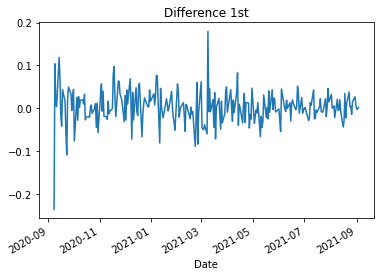

In [15]:
# 1차 차분 구하기
diff2_1 = ts_log2.diff(periods=1).iloc[1:]
diff2_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff2_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.099899e+01
p-value                        6.757151e-20
#Lags Used                     7.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


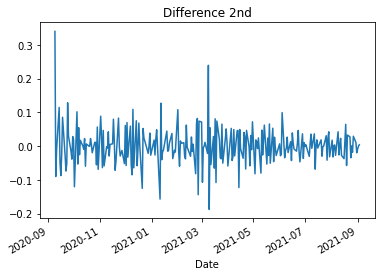

In [16]:
# 2차 차분 구하기
diff2_2 = diff2_1.diff(periods=1).iloc[1:]
diff2_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff2_2)

### d=1에서 부터 d 값을 바꿔 가면서 최적의 값 탐색 예정

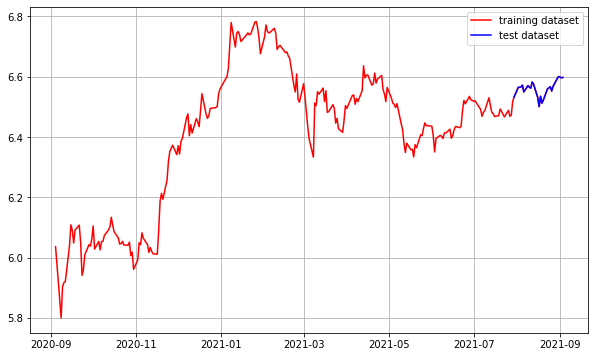

In [17]:
train_data2, test_data2 = ts_log2[:int(len(ts_log2)*0.9)], ts_log2[int(len(ts_log2)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log2, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data2, c='b', label='test dataset')
plt.legend()

In [18]:
# 모델 정의
model2 = ARIMA(train_data2, order=(1, 1, 0))  
fitted_m2 = model2.fit(disp=-1)  
print(fitted_m2.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 399.626
Method:                       css-mle   S.D. of innovations              0.041
Date:                Sat, 04 Sep 2021   AIC                           -793.251
Time:                        14:39:56   BIC                           -783.003
Sample:                             1   HQIC                          -789.115
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0022      0.002      0.896      0.370      -0.003       0.007
ar.L1.D.Close    -0.1015      0.072     -1.410      0.158      -0.243       0.040
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


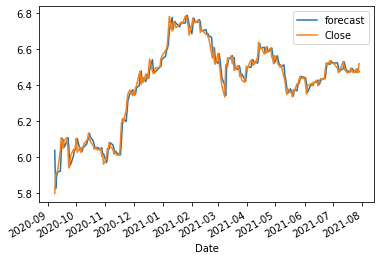

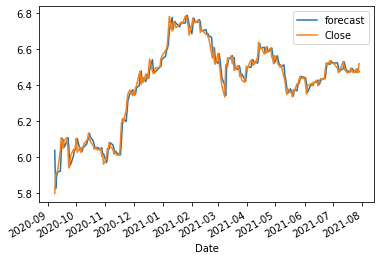

In [19]:
# 훈련 결과
fitted_m2.plot_predict()

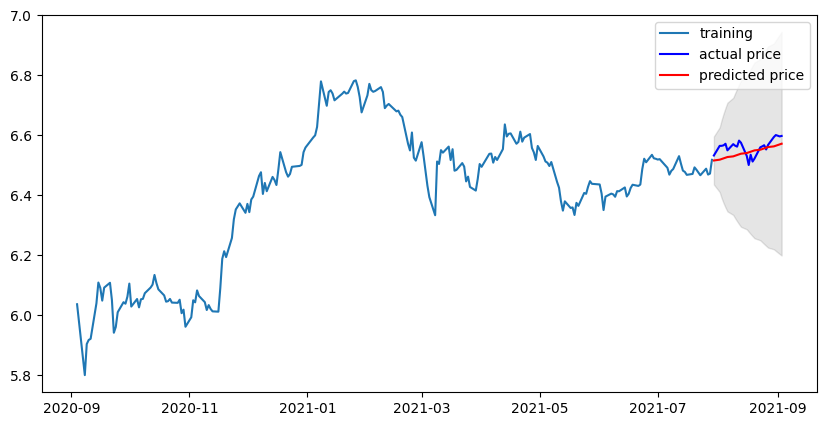

In [20]:
# 테스트 데이터 구간 예측

# Forecast : 결과가 fc에 저장 
fc2, se2, conf2 = fitted_m2.forecast(len(test_data2), alpha=0.05)  # 95% conf

# series로 만듦
fc_series2 = pd.Series(fc2, index=test_data2.index)   # 예측결과
lower_series2 = pd.Series(conf2[:, 0], index=test_data2.index)  # 예측결과의 하한 바운드
upper_series2 = pd.Series(conf2[:, 1], index=test_data2.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data2, label='training')
plt.plot(test_data2, c='b', label='actual price')
plt.plot(fc_series2, c='r',label='predicted price')
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.10)
plt.legend()
plt.show()

In [22]:
# 오차계산

mse2 = mean_squared_error(np.exp(test_data2), np.exp(fc2))
print('MSE: ', mse2)

mae2 = mean_absolute_error(np.exp(test_data2), np.exp(fc2))
print('MAE: ', mae2)

rmse2 = math.sqrt(mean_squared_error(np.exp(test_data2), np.exp(fc2)))
print('RMSE: ', rmse2)

mape2 = np.mean(np.abs(np.exp(fc2) - np.exp(test_data2))/np.abs(np.exp(test_data2)))
print('MAPE: {:.2f}%'.format(mape2*100))

MSE:  468.20941567517536
MAE:  19.399915485461886
RMSE:  21.638147232958172
MAPE: 2.74%


## Google

In [23]:
# 데이터 분리
dataset_filepath3 = os.getenv('HOME') + '/aiffel/stock_prediction/GOOG.csv'
df3 = pd.read_csv(dataset_filepath3, index_col='Date', parse_dates=True)
ts3 = df3['Close']

ts3.head()

Date
2020-09-04    1591.040039
2020-09-08    1532.390015
2020-09-09    1556.959961
2020-09-10    1532.020020
2020-09-11    1520.719971
Name: Close, dtype: float64

In [24]:
# 결측치 확인
ts3[ts3.isna()]

Series([], Name: Close, dtype: float64)

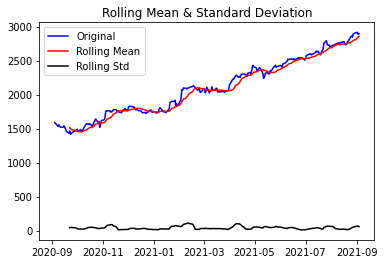

In [25]:
plot_rolling_statistics(ts3, window=12)

In [26]:
# timeseries에 대한 Augmented Dickey-Fuller Test
augmented_dickey_fuller_test(ts3)

Results of Dickey-Fuller Test:
Test Statistic                   0.432371
p-value                          0.982666
#Lags Used                       5.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


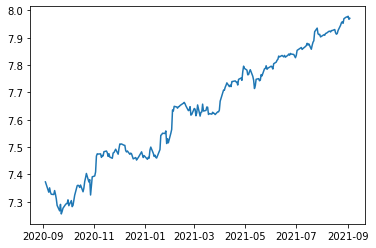

In [27]:
# 로그 변환 시도 
ts_log3 = np.log(ts3)
plt.plot(ts_log3)

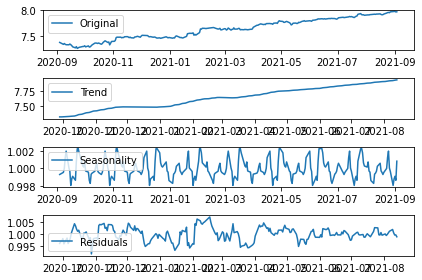

In [28]:
# 시계열 안에 존재하는 trend, seasonality를 직접 분리
decomposition3 = seasonal_decompose(ts_log3, model='multiplicative', period = 30) 

trend3 = decomposition3.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal3 = decomposition3.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual3 = decomposition3.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log3, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend3, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal3,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual3, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [29]:
# Residual에 대한 안정성 여부 판단
residual3.dropna(inplace=True)
augmented_dickey_fuller_test(residual3)

Results of Dickey-Fuller Test:
Test Statistic                  -2.762780
p-value                          0.063790
#Lags Used                      15.000000
Number of Observations Used    206.000000
Critical Value (1%)             -3.462499
Critical Value (5%)             -2.875675
Critical Value (10%)            -2.574304
dtype: float64


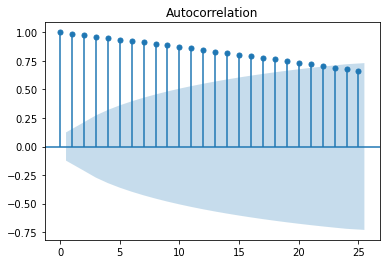

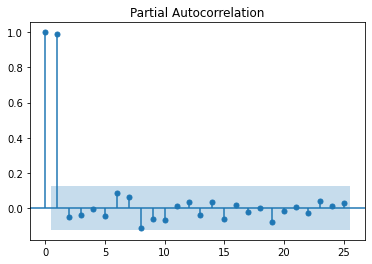

In [30]:
plot_acf(ts_log3)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log3)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### PACF 그래프에서 p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문에 p=1이 매우 적합한 것으로 판단
### ACF는 점차적으로 감소하면서 AR(1) 모델에 유사한 형태를 보이고 있기 때문에 q에 대해서는 적합한 값이 없어 보임

Results of Dickey-Fuller Test:
Test Statistic                -6.486281e+00
p-value                        1.258570e-08
#Lags Used                     6.000000e+00
Number of Observations Used    2.440000e+02
Critical Value (1%)           -3.457438e+00
Critical Value (5%)           -2.873459e+00
Critical Value (10%)          -2.573122e+00
dtype: float64


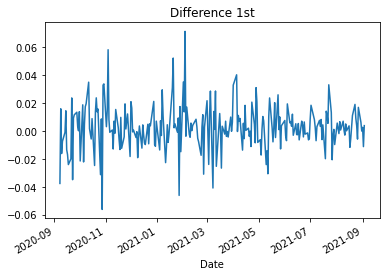

In [31]:
# 1차 차분 구하기
diff3_1 = ts_log3.diff(periods=1).iloc[1:]
diff3_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff3_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.032273e+00
p-value                        6.141705e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


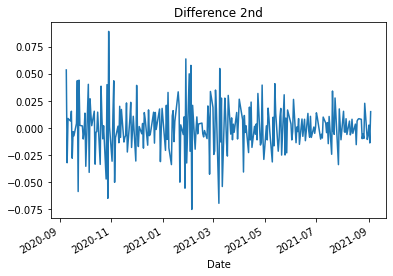

In [32]:
# 2차 차분 구하기
diff3_2 = diff3_1.diff(periods=1).iloc[1:]
diff3_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff3_2)

### d=1에서 부터 d 값을 바꿔 가면서 최적의 값 탐색 예정¶

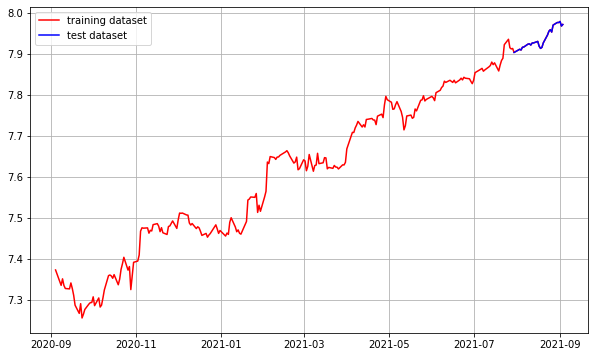

In [33]:
train_data3, test_data3 = ts_log3[:int(len(ts_log3)*0.9)], ts_log3[int(len(ts_log3)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log3, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data3, c='b', label='test dataset')
plt.legend()

In [34]:
# 모델 정의
model3 = ARIMA(train_data3, order=(1, 1, 0))  
fitted_m3 = model3.fit(disp=-1)  
print(fitted_m3.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 603.692
Method:                       css-mle   S.D. of innovations              0.017
Date:                Sat, 04 Sep 2021   AIC                          -1201.385
Time:                        14:49:17   BIC                          -1191.136
Sample:                             1   HQIC                         -1197.248
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.001      2.304      0.021       0.000       0.004
ar.L1.D.Close    -0.0543      0.067     -0.806      0.420      -0.186       0.078
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


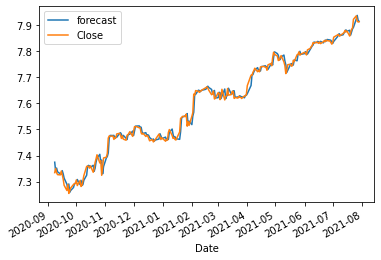

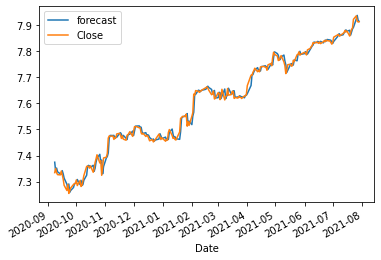

In [35]:
# 훈련 결과
fitted_m3.plot_predict()

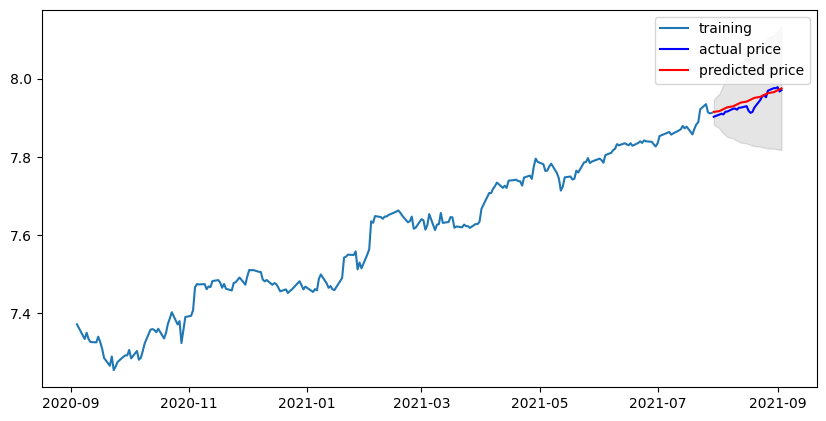

In [36]:
# 테스트 데이터 구간 예측

# Forecast : 결과가 fc에 저장 
fc3, se3, conf3 = fitted_m3.forecast(len(test_data3), alpha=0.05)  # 95% conf

# series로 만듦
fc_series3 = pd.Series(fc3, index=test_data3.index)   # 예측결과
lower_series3 = pd.Series(conf3[:, 0], index=test_data3.index)  # 예측결과의 하한 바운드
upper_series3 = pd.Series(conf3[:, 1], index=test_data3.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data3, label='training')
plt.plot(test_data3, c='b', label='actual price')
plt.plot(fc_series3, c='r',label='predicted price')
plt.fill_between(lower_series3.index, lower_series3, upper_series3, color='k', alpha=.10)
plt.legend()
plt.show()

In [37]:
# 오차계산

mse3 = mean_squared_error(np.exp(test_data3), np.exp(fc3))
print('MSE: ', mse3)

mae3 = mean_absolute_error(np.exp(test_data3), np.exp(fc3))
print('MAE: ', mae3)

rmse3 = math.sqrt(mean_squared_error(np.exp(test_data3), np.exp(fc3)))
print('RMSE: ', rmse3)

mape3 = np.mean(np.abs(np.exp(fc3) - np.exp(test_data3))/np.abs(np.exp(test_data3)))
print('MAPE: {:.2f}%'.format(mape3*100))

MSE:  1610.9124289103445
MAE:  32.7501398309909
RMSE:  40.13617357086179
MAPE: 1.18%


## Apple

In [38]:
# 데이터 분리
dataset_filepath4 = os.getenv('HOME') + '/aiffel/stock_prediction/AAPL.csv'
df4 = pd.read_csv(dataset_filepath4, index_col='Date', parse_dates=True)
ts4 = df4['Close']

ts4.head()

Date
2020-09-04    120.959999
2020-09-08    112.820000
2020-09-09    117.320000
2020-09-10    113.489998
2020-09-11    112.000000
Name: Close, dtype: float64

In [39]:
# 결측치 확인
ts4[ts4.isna()]

Series([], Name: Close, dtype: float64)

In [40]:
# timeseries에 대한 Augmented Dickey-Fuller Test
augmented_dickey_fuller_test(ts4)

Results of Dickey-Fuller Test:
Test Statistic                  -0.967652
p-value                          0.764879
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


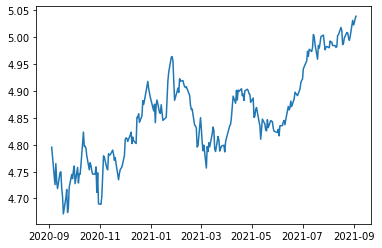

In [41]:
# 로그 변환 시도 
ts_log4 = np.log(ts4)
plt.plot(ts_log4)

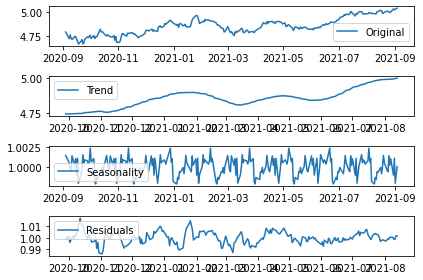

In [42]:
# 시계열 안에 존재하는 trend, seasonality를 직접 분리
decomposition4 = seasonal_decompose(ts_log4, model='multiplicative', period = 30) 

trend4 = decomposition4.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal4 = decomposition4.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual4 = decomposition4.resid # 원본(로그변환한) - 추세 - 계절성

plt.subplot(411)
plt.plot(ts_log4, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend4, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal4,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual4, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [43]:
# Residual에 대한 안정성 여부 판단
residual4.dropna(inplace=True)
augmented_dickey_fuller_test(residual4)

Results of Dickey-Fuller Test:
Test Statistic                  -5.425923
p-value                          0.000003
#Lags Used                       0.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64


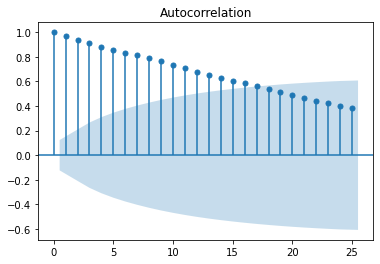

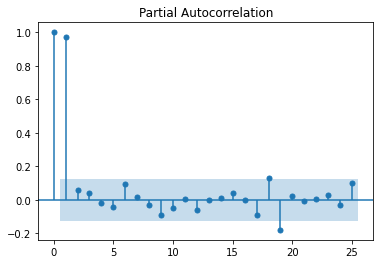

In [44]:
plot_acf(ts_log4)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log4)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### PACF 그래프에서 p가 2 이상인 구간에서 PACF는 거의 0에 가까워지고 있기 때문에 p=1이 매우 적합한 것으로 판단
### ACF는 점차적으로 감소하면서 AR(1) 모델에 유사한 형태를 보이고 있기 때문에 q에 대해서는 적합한 값이 없어 보임

Results of Dickey-Fuller Test:
Test Statistic                -1.858518e+01
p-value                        2.076057e-30
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


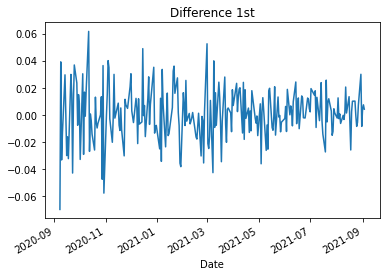

In [45]:
# 1차 차분 구하기
diff4_1 = ts_log4.diff(periods=1).iloc[1:]
diff4_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff4_1)

Results of Dickey-Fuller Test:
Test Statistic                -7.360608e+00
p-value                        9.522578e-11
#Lags Used                     1.600000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


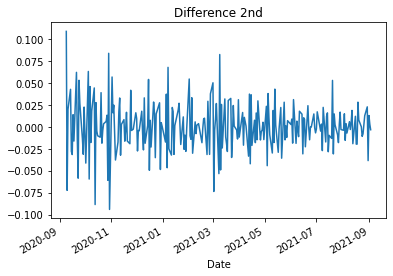

In [46]:
# 2차 차분 구하기
diff4_2 = diff4_1.diff(periods=1).iloc[1:]
diff4_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff4_2)

### d=1에서 부터 d 값을 바꿔 가면서 최적의 값 탐색 예정¶

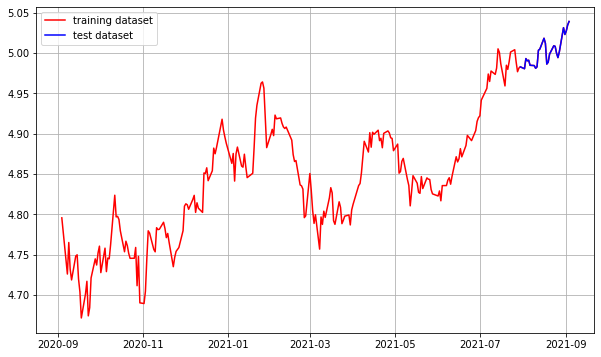

In [47]:
train_data4, test_data4 = ts_log4[:int(len(ts_log4)*0.9)], ts_log4[int(len(ts_log4)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log4, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data4, c='b', label='test dataset')
plt.legend()

In [48]:
# 모델 정의
model4 = ARIMA(train_data4, order=(1, 1, 0))  
fitted_m4 = model4.fit(disp=-1)  
print(fitted_m4.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 567.058
Method:                       css-mle   S.D. of innovations              0.019
Date:                Sat, 04 Sep 2021   AIC                          -1128.116
Time:                        15:00:21   BIC                          -1117.868
Sample:                             1   HQIC                         -1123.980
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0009      0.001      0.764      0.445      -0.001       0.003
ar.L1.D.Close    -0.1487      0.068     -2.194      0.028      -0.282      -0.016
                                    Root

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


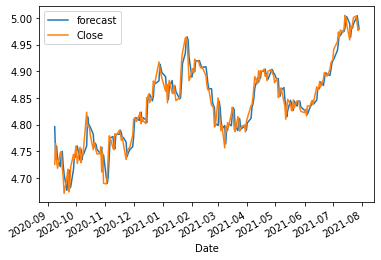

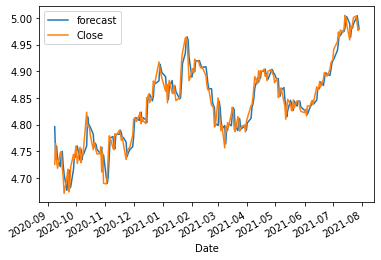

In [49]:
# 훈련 결과
fitted_m4.plot_predict()

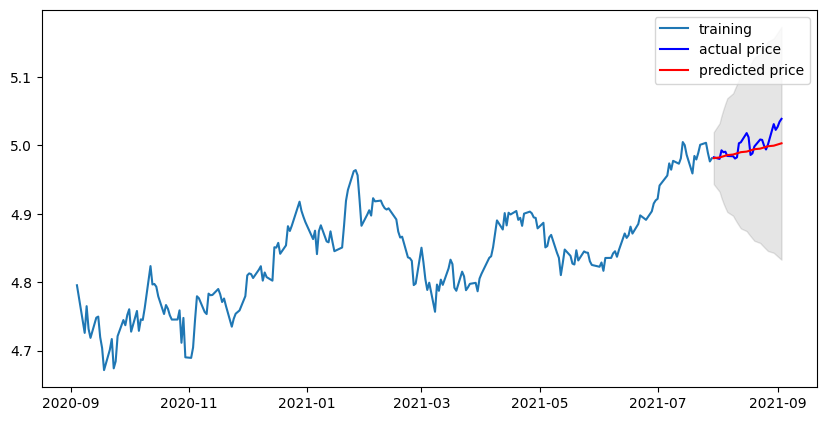

In [50]:
# 테스트 데이터 구간 예측

# Forecast : 결과가 fc에 저장 
fc4, se4, conf4 = fitted_m4.forecast(len(test_data4), alpha=0.05)  # 95% conf

# series로 만듦
fc_series4 = pd.Series(fc4, index=test_data4.index)   # 예측결과
lower_series4 = pd.Series(conf4[:, 0], index=test_data4.index)  # 예측결과의 하한 바운드
upper_series4 = pd.Series(conf4[:, 1], index=test_data4.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data4, label='training')
plt.plot(test_data4, c='b', label='actual price')
plt.plot(fc_series4, c='r',label='predicted price')
plt.fill_between(lower_series4.index, lower_series4, upper_series4, color='k', alpha=.10)
plt.legend()
plt.show()

In [51]:
# 오차계산

mse4 = mean_squared_error(np.exp(test_data4), np.exp(fc4))
print('MSE: ', mse4)

mae4 = mean_absolute_error(np.exp(test_data4), np.exp(fc4))
print('MAE: ', mae4)

rmse4 = math.sqrt(mean_squared_error(np.exp(test_data4), np.exp(fc4)))
print('RMSE: ', rmse4)

mape4 = np.mean(np.abs(np.exp(fc4) - np.exp(test_data4))/np.abs(np.exp(test_data4)))
print('MAPE: {:.2f}%'.format(mape4*100))

MSE:  5.820080964563927
MAE:  1.8049682423740263
RMSE:  2.4124843967503558
MAPE: 1.20%


# 회고
- 이번 프로젝트에서 어려웠던 점
    - 용어들이 생소해서 이해하는 데 오래 걸렸다.
- 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
    - 각 경우에 따라 어떤 평가 지표를 써야하는지 잘 모르겠다.
- 자기 다짐
    - 모든 것을 다 이해하기는 어려우니 타켓을 잡은 분야를 좀 더 집중해야겠다.